In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
v_th=0.6
SC_base_dir= '/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_tracks_conmats/data/results/hcp_wuminn/tractography/dipy/l2k8/'
TS_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
out_dir =  '/brunhild/mcintosh_lab/jwang/ModelFitting/Deco/' #'/brunhild/mcintosh_lab/jwang/ModelFitting/Linear_gains/'
import pandas as pd
#groups =[grp for grp in os.listdir(base_dir)]
TS_df=pd.read_pickle('/scratch/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts_LATEST/data/results/100307_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl')

In [3]:
TS=TS_df.values

In [4]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x
def f_diffusion_tr_noise(X, Wo, Theta):
    
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    G = 5000.0/0.4590/0.641  + 1000.*np.tanh(Theta[3:4])
    #G=5000.0/0.4590/0.641 + smooth_normalize(Theta[4:5])
    #W_n = np.reshape(Theta[5:], [batch_size,batch_size])
    #W_n = 1+ np.tanh((W_n+W_n.T)/2.0)
    #W_n = W_n * Wo
    
    #Ws = W_n/np.linalg.norm(W_n)
    gEI= 1.0 #0.1 + smooth_normalize(Theta[0:1])
    W1= .1 + smooth_normalize(Theta[0:1])
    #gEE= 0.15* (1+np.tanh(Theta[2:3])/5.0)
    gEE= 0.001 + smooth_normalize(Theta[1:2])
    gIE= 0.1+smooth_normalize(Theta[2:3])
    #Tr= 1.
    #step_size = 0.05
    num_para = 0
    dt = step_size
    state_size = np.int(Tr/step_size)
    N=1
    #ROI_size=96
    #Jnmda = 0.15
    #W=(Gi*W0)/np.linalg.norm(Gi*W0)
    L_s = -np.diag(np.sum(Wo, axis= 1)) + Wo
    #L_s = -np.diag(np.sum(Ws, axis= 1)) + Ws
    I0 = 0.3772/1.
    gamma = 0.641/1000.
    gammaI = 1.0/1000.
    #Wplus = .8
    Ie = 0
     #smooth_normalize_ct(_Ji[:,0],1.0)
    aE = 310
    bE = 125
    dE_0 = 0.16
    WE = 1.0 #18.4576#1.0
    
    aI = 615
    bI = 177
    dI_0 = 0.087
    WI = 0.7
    
    tauE = 100.
    tauI = 10.
    
    
    #W1= 0.05
    
    #G = .1
    
    E = X[num_para:num_para+N*ROI_size]#smooth_normalize_ct(X[num_para:num_para+N*ROI_size], 0.5)
    I = X[num_para+N*ROI_size:num_para+2*N*ROI_size]#smooth_normalize_ct(X[num_para+N*ROI_size:num_para+2*N*ROI_size], .5)
    q = X[-N*ROI_size:] #smooth_normalize_ct(X[-N*ROI_size:],1.0)
    v = X[-2*N*ROI_size:-N*ROI_size]#smooth_normalize_ct(X[-2*N*ROI_size:-N*ROI_size],1.)
    f = X[-3*N*ROI_size:-2*N*ROI_size]#smooth_normalize_ct(X[-3*N*ROI_size:-2*N*ROI_size], 1.)
    x = X[-4*N*ROI_size:-3*N*ROI_size]#np.tanh(X[-4*N*ROI_size:-3*N*ROI_size])#smooth_normalize(X[-4*N*ROI_size:-3*N*ROI_size], .5)
    #print(E.shape)
    #subID='AD_016_S_4902.mat'
    
    
    rho=0.34;
    tau_0=0.98;
    #tau_s=0.8;
    #tau_f=0.4;
    alpha =0.32;
    #s=0.5;
    #E = np.tanh(E/200.0)
    #I =np.tanh(I/200.0)
    def fout(v, k):
        return (k*v)**(1.0/alpha)/k
    def Ef(f,k):
        return 1.0-(1.0- rho)**(1.0/f/k)
    
    
    k = 1.
    #x=x/(np.max(np.abs(x))+0.002)
    #print E.shape
    sigma = 1.
    
    epsilon = 1.0 #+ 0.2 *np.tanh(Theta[5:6]) # smooth_normalize(X[5:6], 0.5)
    tau_s = 0.65 #+ 0.2 *np.tanh(Theta[6:7])
    tau_f = 0.41 #+ 0.2 *np.tanh(Theta[7:8])
    for i in range(state_size):
        
        IE = 1*WE*I0 + gEE*E + G*np.dot(L_s, E) -gIE*(I) + Ie
        II = WI*I0 + gEI*E - I 
         
        dE =  E - dt*(E+gamma*3.0631*tauE)/tauE \
           -dt*E*gamma*(3.0631+0.4590*np.tanh(IE- 0.3772)) + dt*gamma*(3.0631+0.4590*(IE - 0.3772))\
                +W1*np.sqrt(dt/state_size)*np.random.randn(ROI_size)
            
        
        dI =  I - dt*(I)/tauI \
             + dt*gammaI*sigmoid(aI, bI, dI_0, II)\
            +W1*np.sqrt(dt/state_size)*np.random.randn(ROI_size)
        
        
        dx = x+dt*(epsilon*(E)/sigma \
                   -1.0/tau_s*x \
               -1.0/tau_f *(k*f-1))
        f_tmp= f+dt*1/k*x
        dv= v+dt*(f/tau_0 -fout(v,k)/tau_0)
        dq= q+ dt*(f*Ef(f,k)/rho/tau_0\
                  -q/v*fout(v,k)/tau_0)
        df = f_tmp
        
        x = np.tanh(dx) #smooth_normalize(dx, 0.5)
        v = smooth_normalize_ct(dv, 1.0) #a+ b*np.tanh((dv-a)/b)
        f = smooth_normalize_ct(df, 1.0) #a+ b*np.tanh((df-a)/b)
        q = smooth_normalize_ct(dq, 1.0) #a+ b*np.tanh((dq-a)/b)
        E = np.tanh(dE)#1.0 + np.tanh(dE - 1.0) #smooth_normalize_ct(dE, 1.0)#np.tanh(dE/200.0)
        I = np.tanh(dI)#1.0 + np.tanh(dI - 1.0)#smooth_normalize_ct(dI, 1.0)#np.tanh(dI/200.0)
    """return np.concatenate((g1,g2,g12,g21,sigma,epsilon,tau_s,tau_f,\
                           E, I, x, f, v, q))"""
    return np.concatenate((E, I, x, f, v, q))

def h_diffusion_noise(X, Theta):
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (a*x-b)/(1.0000-np.exp(-d*(a*x-b)))
    
    W2= 0.02 #Theta[3:4]#0.02 + smooth_normalize(Theta[3:4])
    E0=0.34
    rho=0.34
    k1 = 7*E0
    k2 = 2.
    k3 = 2*E0-0.2
    #w= Theta[3:4]
    #W2 = 0.01
    V = 0.02 #1.0 + smooth_normalize(Theta[9:10])
    #V= 30.0
    q = smooth_normalize_ct(X[-ROI_size:],1.0)
    v = smooth_normalize_ct(X[-2*ROI_size:-ROI_size],1.0)
    k= 1.
    #v = a+ a*np.tanh((v-a)/a)/1.1
    y= k1*(1-k*q)+k2*(1-q/v)+k3*(1-k*v)
    #q = a+ a*np.tanh((q-a)/a)/1.1
    return 100.0/E0*V*(y)+W2*np.random.randn(ROI_size)

In [5]:
Tr= 2.
num_epochs =30*1
echo_step = 1
num_data = TS.shape[0]
truncated_backprop_length = 15
total_series_length = num_data -echo_step #50000

step_size = 0.1
state_size = 6 #np.int(6* Tr/step_size)

num_classes = 1
batch_size = 83
num_batches = total_series_length//truncated_backprop_length

In [6]:
num_data

1200

In [24]:
tf.reset_default_graph()
    
    
L_new = tf.placeholder(tf.float32, [batch_size, batch_size])
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, 1+truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size)])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])



def fout(v):
    return tf.pow(v, tf.constant(1./.2, dtype=tf.float32))
def Ef(f):
    rho = 0.34
    return tf.constant(1., dtype=tf.float32)-tf.pow(tf.constant(1.-rho, dtype=tf.float32), tf.reciprocal(f))
def h_tf(a, b, d, x):
    return (a*x-b)/(1.00001 -tf.exp(-d*(a*x-b)))

def smooth_normalize_ct(x, center, d_min, d_rate):
    x_n = center+ (center-tf.constant(0.00001, dtype=tf.float32) )*tf.tanh((x-center)/(center - tf.constant(0.001, dtype=tf.float32)))
    
    return d_min + d_rate*x_n





sigma = tf.constant(1.0, dtype=tf.float32) 
epsilon = tf.constant(1.0, dtype=tf.float32)# + 0.3 *np.tanh(X[5:6]) # smooth_normalize(X[5:6], 0.5)
tau_s = tf.constant(0.65, dtype=tf.float32)# + 0.2 *np.tanh(X[6:7])
tau_f = tf.constant(0.41, dtype=tf.float32)# + 0.3 *np.tanh(X[7:8])

I0=tf.constant(0.3772, dtype=tf.float32)
gamma = tf.constant(0.641/1000.0, dtype=tf.float32)
gammaI = tf.constant(1/1000.0, dtype=tf.float32)

Ie = tf.constant(0.0, dtype=tf.float32)

aE=tf.constant(310, dtype=tf.float32)
bE = tf.constant(125, dtype=tf.float32)
dE =tf.constant(0.16, dtype=tf.float32)
WE= tf.constant(1, dtype=tf.float32)
tauE= tf.constant(100, dtype=tf.float32)

aI=tf.constant(615, dtype=tf.float32)
bI = tf.constant(177, dtype=tf.float32)
dI =tf.constant(0.087, dtype=tf.float32)
WI= tf.constant(0.7, dtype=tf.float32)
tauI= tf.constant(10, dtype=tf.float32)

rho=tf.constant(0.34, dtype=tf.float32)
E0=tf.constant(0.34, dtype=tf.float32)
k1 = tf.constant(7*0.34, dtype=tf.float32)
k2 =tf.constant( 2, dtype=tf.float32)
k3 = tf.constant(2*0.34-0.2, dtype=tf.float32)
   
V = tf.constant(0.02, dtype=tf.float32)
rho= tf.constant(0.34, dtype=tf.float32)
tau_0= tf.constant(0.98, dtype=tf.float32) 
    #tau_s=0.8;
    #tau_f=0.4;
alpha =tf.constant(0.32, dtype=tf.float32)

dt=tf.constant(step_size, dtype=tf.float32)
   
E_fr= tf.constant(np.zeros((batch_size,1)), dtype=tf.float32)

#gi0 = 1.* np.zeros((batch_size,1))
#Ws0 = np.zeros((batch_size,batch_size))+0.05
g0 = 0.
   
W1 = tf.Variable(0.5, dtype=tf.float32)
gEE =tf.Variable(0.15, dtype=tf.float32)
G = tf.Variable(g0, dtype=tf.float32)
#Gi = tf.Variable(gi0, dtype=tf.float32)
#Ws = tf.Variable(Ws0, dtype=tf.float32)
gEI = tf.constant(1.0, dtype=tf.float32)

gIE = tf.Variable(1.0, dtype=tf.float32)   
    

# Unpack columns

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

#W_n= 1+tf.tanh((Ws+tf.transpose(Ws))/2.0)
#W_n = W_n * L_new

#W_s =W_n/tf.norm(W_n)
L= -tf.diag(tf.reduce_sum(L_new, axis=1)) + L_new
#L= -tf.diag(tf.reduce_sum(W_s, axis=1)) + W_s


# Forward pass
current_state = init_state
#current_state = _current_state
states_series = []
inhi_series = []
logits_series = []
noise2 = inputs_series[-truncated_backprop_length-1:-1]
noise_c = inputs_series[-1]


for j, label_tmp in enumerate(labels_series):
    #current_input = tf.reshape(current_input, [batch_size, 1])
    #input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    
    
  
    E=current_state[:,0:1]
    I=current_state[:,1:2]
    x=current_state[:,2:3]
    f=current_state[:,3:4]
    v=current_state[:,4:5]
    q=current_state[:,5:6]
    
    G_p = 5000./0.641/0.459 +1000.*tf.tanh(G)
    #G_p = 5000./0.641/0.459 +tf.nn.relu(G)
    gIE_p = 0.1+ tf.nn.relu(gIE) #smooth_normalize_ct(Ji, tf.constant(1.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
    
    #gEI_p =0.1+tf.nn.relu(gEI)
    gEE_p =0.001+ tf.nn.relu(gEE)
    
    
    W1_p = .1 + tf.nn.relu(W1)
    #W2_p = 0.01 + tf.nn.relu(W2)
    #W = (Gi_p*L_new)/tf.norm(Gi_p*L_new)
    #L = -tf.diag(tf.reduce_sum(W, axis=1)) + W
    for i in range(np.int(Tr/step_size)):
        noise = tf.reshape(inputs_series[j*np.int(Tr/step_size)+i],[batch_size, 1] )
        noise1 = tf.reshape(inputs_series[truncated_backprop_length*np.int(Tr/step_size)\
                                          +j*np.int(Tr/step_size)+i],[batch_size, 1] )
        IE = WE*I0 + gEE_p*E + G_p*tf.matmul(L, E) -gIE_p*(I) + Ie
        II = WI*I0 + gEI*E - I
        
        #IE = 125/310.0 -0.026 +0.006*tf.tanh(IE/100. - 125/310.0 + 0.026) 
        #(3.0631+0.4869*tf.tanh(h_tf(aE, bE, dE, IE)-3.0631)) 
        E_new =E - dt*(E+gamma*tauE*3.0631)/tauE \
                    + dt*gamma*(3.0631+0.4590*(IE-0.3772))\
                     - dt*E*gamma*(3.0631+0.4590*tf.tanh(IE-0.3772))\
                    +W1_p*tf.sqrt(dt/tf.constant(Tr/step_size, dtype=tf.float32))*noise
        I_new =I - dt*(I)/tauI \
                   + dt*gammaI*h_tf(aI, bI, dI, II) \
                   +W1_p*tf.sqrt(dt/tf.constant(Tr/step_size, dtype=tf.float32))*noise1
    
    
        dx = x+dt*(epsilon*E/sigma\
                   -tf.constant(1., dtype=tf.float32)/tau_s*x  \
                   -tf.constant(1., dtype=tf.float32)/tau_f*(f-tf.constant(1., dtype=tf.float32)))
        f_tmp= f+dt*x 
        dv= v+dt*(f/tau_0 -fout(v)/tau_0) 
        dq=q+ dt*(tf.multiply(f,Ef(f))/rho/tau_0-tf.multiply(tf.divide(q,v) ,fout(v)) /tau_0)
        v=smooth_normalize_ct(dv, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        q=smooth_normalize_ct(dq, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        f=smooth_normalize_ct(f_tmp, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        x= tf.tanh(dx)
        E= tf.tanh(E_new) #smooth_normalize_ct(E_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        I= tf.tanh(I_new) #smooth_normalize_ct(I_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        
        #E_fr = sigmoid_tf(aE, bE, dE, IE)
    next_state = tf.concat([E, I, x, f, v, q],1)  # Broadcasted addition
    #IE = WE*I0 + Wplus_p*Jnmda_p*E + G_p*Jnmda_p*tf.matmul(W, E) -tf.multiply(Ji_p,I) + Ie
    #E_fr = h_tf(aE, bE, dE, IE)
    states_series.append(next_state)
    #inhi_series.append(E_fr)
    current_state = next_state 
#current_state = states_series[0]
print(states_series[0].shape)
print(inputs_series[0].shape)
print(len(inputs_series))
#logits_series = [tf.reshape(tf.matmul(W2, tf.reshape(tf.tanh(state), [batch_size*state_size, 1])) + b2, [batch_size,]) for state in states_series]#Broadcasted addition

logits_series = [100/E0*V*(k1*(tf.constant(1., dtype=tf.float32)-state[:, 5])\
                 +k2*(tf.constant(1., dtype=tf.float32)-tf.divide(state[:, 5],state[:, 4]))\
                 +k3*(tf.constant(1., dtype=tf.float32)-state[:, 4]))\
                 +0.02*noise   for state, noise in zip(states_series, noise2)]
print(logits_series[0].shape)
print(labels_series[0].shape)

predictions_series = logits_series

labels_series_tf = tf.stack(labels_series,axis=1)
logits_series_tf = tf.stack(logits_series,axis=1)
#labels_series_tf = labels_series[0]
#logits_series_tf = states_series[0]
labels_series_tf_n = labels_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(labels_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))
logits_series_tf_n = logits_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(logits_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))


cov_sim =tf.matmul(logits_series_tf_n, tf.transpose(logits_series_tf_n))
cov_def= tf.matmul(labels_series_tf_n, tf.transpose(labels_series_tf_n))


FC_sim_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))), cov_sim), \
                     tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))))
FC_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def)))), cov_def), \
                 tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def))))) 
#FC_T= tf.constant(FC, dtype=tf.float32)

#ones_tri=tf.matrix_band_part(tf.ones_like(FC_T)-tf.diag(tf.ones((batch_size,))), 0, -1)
#zeros = tf.zeros_like(FC_T) # create a tensor all ones
#mask = tf.greater(ones_tri, zeros) # boolean tensor, mask[i] = True iff x[i] > 1
ones_tri=np.tril(np.ones((batch_size,batch_size)),-1)
ones_tri[0,0]=.25*np.sqrt(82)

FC_tri_v = tf.boolean_mask(FC_T, ones_tri>0)

FC_v = FC_tri_v #- tf.reduce_mean(FC_tri_v)*tf.ones_like(FC_tri_v)
#print(tf.shape(FC_v))

FC_sim_tri_v = tf.boolean_mask(FC_sim_T, ones_tri>0)
FC_sim_v = FC_sim_tri_v #- tf.reduce_mean(FC_sim_tri_v)*tf.ones_like(FC_sim_tri_v)

corr_FC =tf.reduce_sum(tf.multiply(FC_v,FC_sim_v))\
                  /tf.sqrt(tf.reduce_sum(tf.multiply(FC_v,FC_v)))\
                /tf.sqrt(tf.reduce_sum(tf.multiply(FC_sim_v,FC_sim_v)))
        
losses_corr = tf.square(1- corr_FC)
losses = tf.sqrt(tf.reduce_mean(tf.multiply(FC_sim_v-FC_v, FC_sim_v-FC_v)))
#losses = tf.sqrt(tf.reduce_mean(tf.multiply(cov_sim-cov_def, cov_sim-cov_def)))

    
total_loss = losses_corr #+ 0.05*W1**2
      

#losses = [tf.losses.mean_squared_error(labels, logits) for logits, labels in zip(logits_series,labels_series)]

#total_loss = tf.reduce_mean(losses) #+ 0.01*(g1**2 + 2*g12**2 + g21**2)


opt_func = tf.train.AdamOptimizer(.01)




train_step=opt_func.minimize(total_loss)
#train_step = tf.train.GradientDescentOptimizer(.05).minimize(total_loss)
#train_step = tf.train.MomentumOptimizer(learning_rate=0.08, momentum=0.9).minimize(total_loss)
#train_step = tf.train.AdamOptimizer(0.02).minimize(total_loss)
def plot(batch_idx,  y_array,x_array, params_list, loss_list, batchX, batchY):
       
    plt.subplot(2, 2, 1)
    plt.cla()
    plt.plot(loss_list)
    
    plt.subplot(2, 2, 2)
    plt.cla()
    plt.plot(params_list)
    
    
    """plt.subplot(2, 2, 3)
    plt.cla()
    plt.imshow(W_s)"""
    
    
    plt.subplot(2, 2, 4)
    plt.cla()
    plt.plot(y_array.T)

    
        
    plt.draw()
    plt.pause(0.0001)

(83, 6)
(83,)
616
(83,)
(83,)


In [27]:
def model_run(subID,L_s, TS):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        plt.ion()
        plt.figure()
        plt.show()
        loss_list = []
        params_list = []
        
        
       
        #Ws_old = list(np.zeros((83,83)).ravel())
        gEI_old = .15
        W1_old = 0.5
        gEE_old = .15
        gIE_old = 1.
        G_old = 100.
   
        loss_array_old = np.zeros((truncated_backprop_length,))
    
    
        for epoch_idx in range(num_epochs):
        
            TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
            y_in= TS.T[:,echo_step:num_data]/np.max(TS)
            if len(loss_list) == 0 or loss_list[len(loss_list)-1]> 0.002:
            
                y_array =np.zeros((batch_size,num_batches*truncated_backprop_length))
                x_array =np.zeros((batch_size,num_batches*truncated_backprop_length))
                
                initi_con = .1*(np.random.uniform(-1,1,[batch_size, state_size])+np.array([[0, 0, 0,1.1,1.1,1.1]]))
                #initi_con[:,0:2]= 0
                _current_state = initi_con
            
            
                params_old = np.array([W1_old,  gEE_old, gIE_old, G_old] )
                #print("New data, epoch", epoch_idx)
                loss_array = np.zeros((num_batches,))
                for batch_idx in range(num_batches):
                
                    
                    #for batch_idx in range(209-truncated_backprop_length):
                    start_idx = batch_idx * truncated_backprop_length
                    #start_idx = batch_idx 
                    end_idx = start_idx + truncated_backprop_length

                    batchX = np.random.randn(batch_size, 1+truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size))
                    batchY = y_in[:,start_idx:end_idx]

                    _G, _gIE, _W1, _gEE, _total_loss, _train_step, _current_state,\
                               _logits_series, _inhi_series = sess.run(
                    [G, gIE, W1, gEE, total_loss, train_step, current_state, logits_series, inhi_series],
                    feed_dict={
                        batchX_placeholder:batchX,
                        batchY_placeholder:batchY,
                        init_state:_current_state,
                        L_new:L_s
                        })

                    loss_list.append(_total_loss)
                    params_new = np.array([_W1, _gEE, _gIE, _G])#1/(1+np.exp(-_W1))
                    params_list.append(params_new)
                    
                    
                    loss_array[batch_idx] = _total_loss
                
                    for i in range(truncated_backprop_length):
                        start_idx = batch_idx * truncated_backprop_length
                
                        y_array[:, start_idx+i] = _logits_series[i]
                   
                
                
                    #print("Step",batch_idx, "Loss", _total_loss)
                
                
        
       
            
    plot(batch_idx,  y_array, x_array, params_list, loss_list,  batchX, batchY)        
    plt.ioff()
    plt.show()
    #print(Ji_list)
    np.savetxt(out_dir+'HCP_'+subID+'paramsList_test1.txt', np.array(params_list))
    #np.savetxt(Out_path+'PPMI_'+subID+'Ji.txt', np.array(Ji_list))
    np.savetxt(out_dir+'HCP_'+subID+'sim_fitting_bold_test1.txt', y_array.T)
    #y_dmean =(y_array.T -y_array.T.mean(axis= 0)).T
    FC_sim = np.corrcoef(y_array[:,10:])
    
    FC = np.corrcoef(TS.T)
    corr_simfit= np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1]
    print(corr_simfit)
    HCP_par_corr[subID].append(corr_simfit)
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ax[0].plot(TS)
    img1 =ax[1].imshow(FC_sim -np.diag(np.diag(FC_sim)), cmap='bwr')
    plt.colorbar(img1, ax=ax[1], fraction=0.046, pad=0.04)
    img2 =ax[2].imshow(FC, cmap='bwr')
    plt.colorbar(img2, ax=ax[2], fraction=0.046, pad=0.04)
    plt.show()


0 156233
1 209329
2 154532


<Figure size 432x288 with 0 Axes>

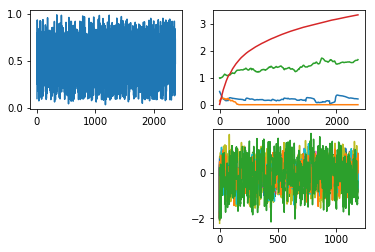

0.38825792550605004


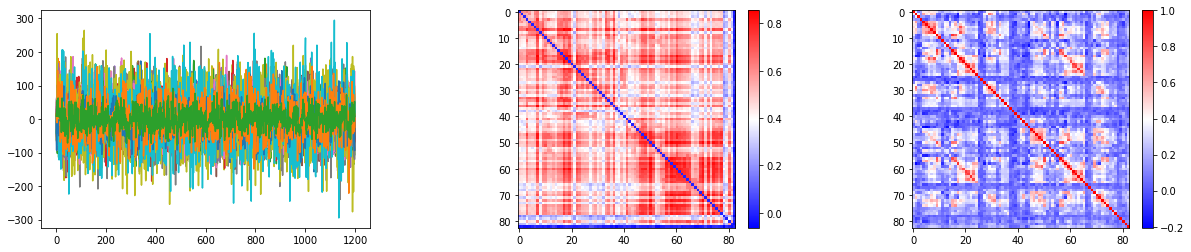

0.408422354678522


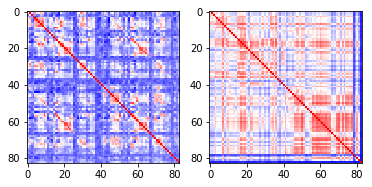

<Figure size 432x288 with 0 Axes>

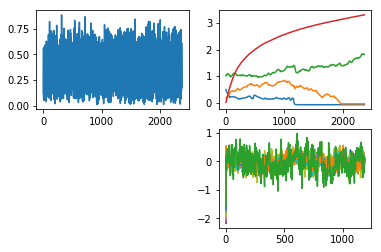

0.9565587889409986


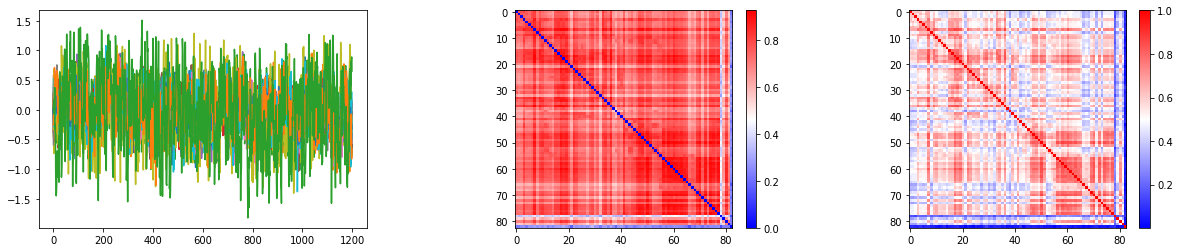

[0.38825792550605004, 0.3137482970952988, 0.001001, 1.7624737143516542, 17991.621872247077, 0.9565587889409986, 0.100001, 0.001001, 1.9214813590049744, 17991.47255786589]
3 172332


<Figure size 432x288 with 0 Axes>

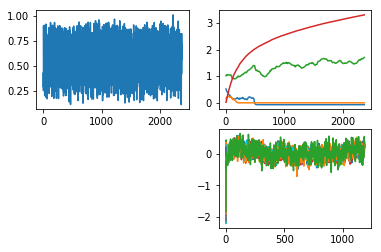

0.28184483288190154


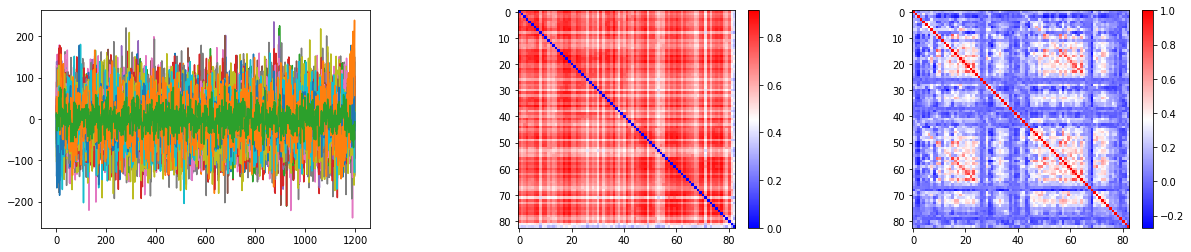

0.3099586137440601


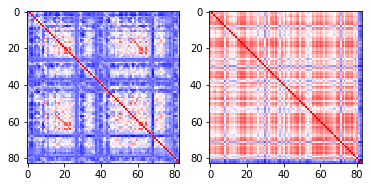

<Figure size 432x288 with 0 Axes>

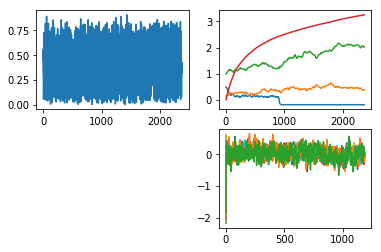

0.9799971424315731


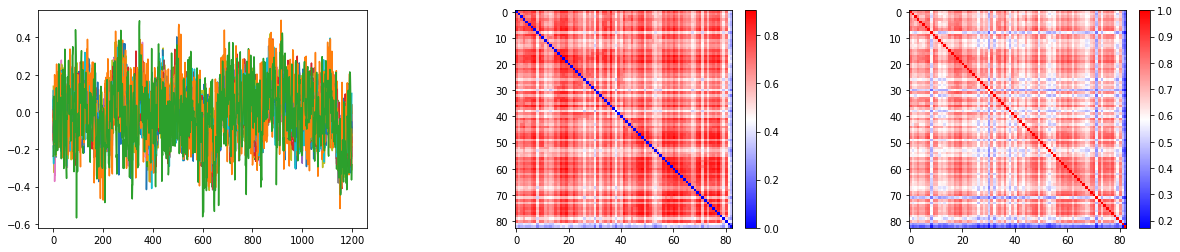

[0.28184483288190154, 0.100001, 0.001001, 1.7905225396156312, 17991.46425438688, 0.9799971424315731, 0.100001, 0.3822871158123016, 2.1208187818527224, 17991.136038466637]
4 181131


<Figure size 432x288 with 0 Axes>

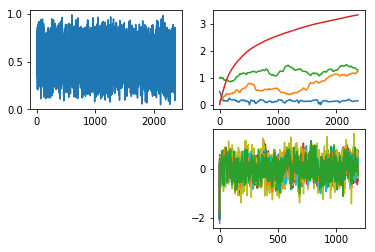

0.39454559474334944


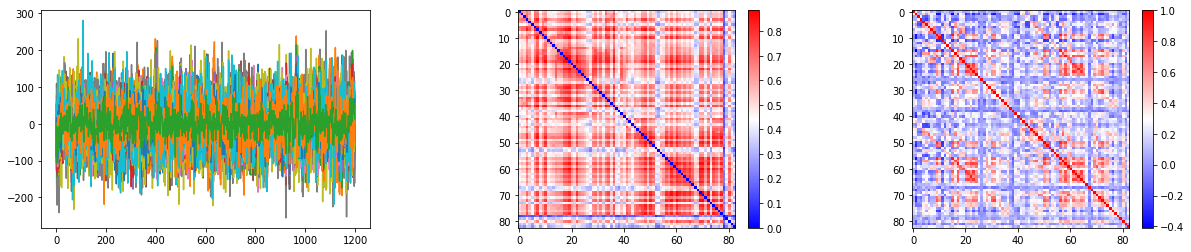

0.39850174202718336


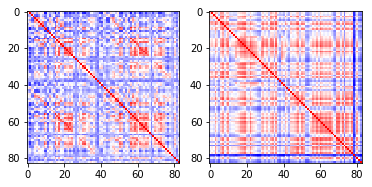

<Figure size 432x288 with 0 Axes>

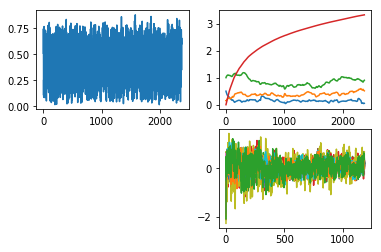

0.9788310053034808


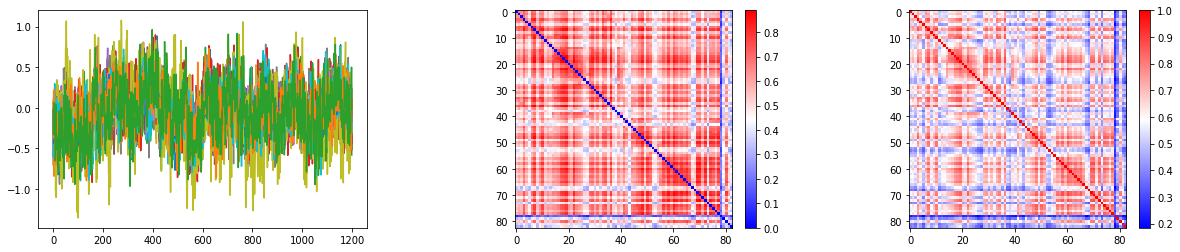

[0.39454559474334944, 0.2435328483581543, 1.2278986344337461, 1.3900275945663454, 17991.583496753865, 0.9788310053034808, 0.1572226148098707, 0.5335612127780914, 1.0007969677448274, 17991.582641154848]
5 317332


<Figure size 432x288 with 0 Axes>

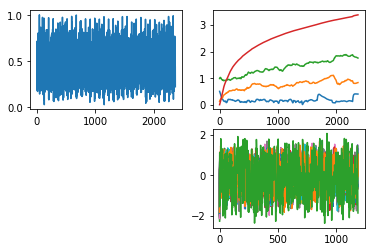

0.35702967854190365


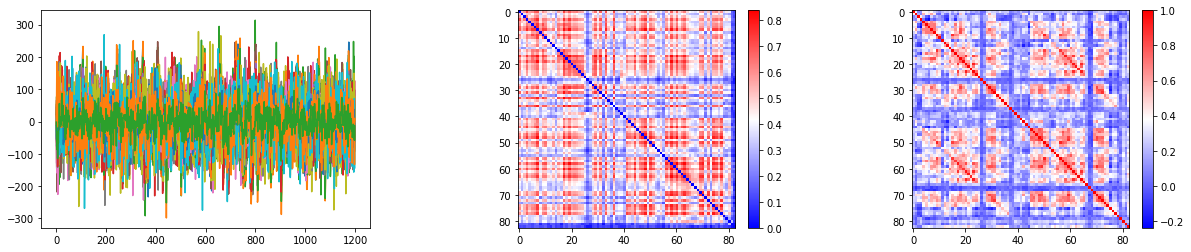

0.3563102971768149


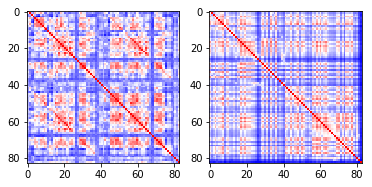

<Figure size 432x288 with 0 Axes>

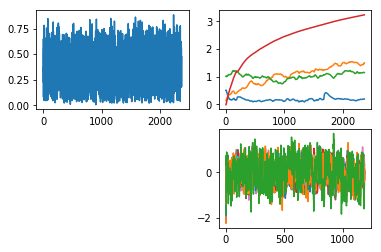

0.9721078521983185


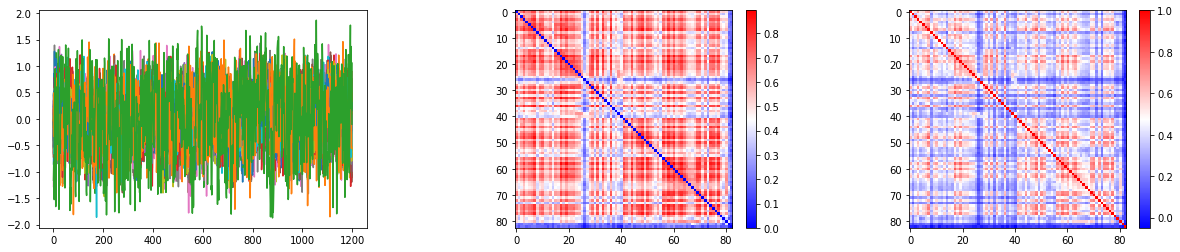

[0.35702967854190365, 0.5097254782915115, 0.837332356929779, 1.859971809387207, 17991.805693796563, 0.9721078521983185, 0.29515508413314817, 1.4961371312141418, 1.2576594591140748, 17991.041905733116]
6 196750


<Figure size 432x288 with 0 Axes>

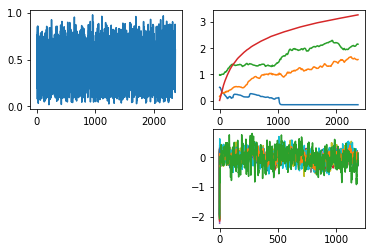

0.408480002780141


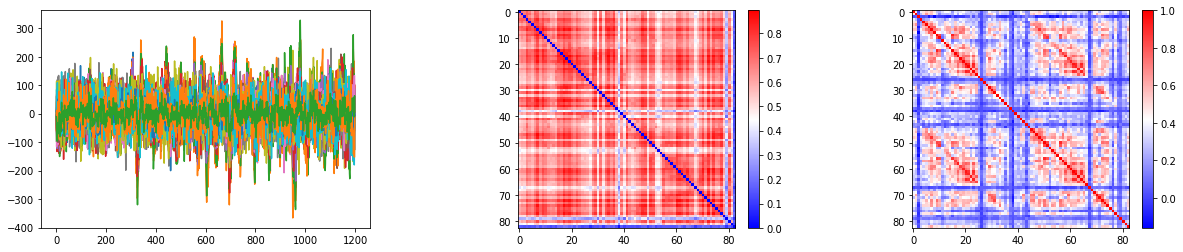

0.4081138643654998


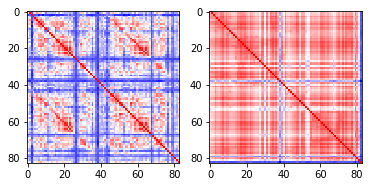

<Figure size 432x288 with 0 Axes>

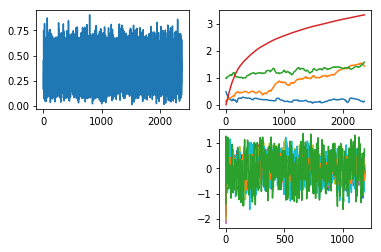

0.9576935649997489


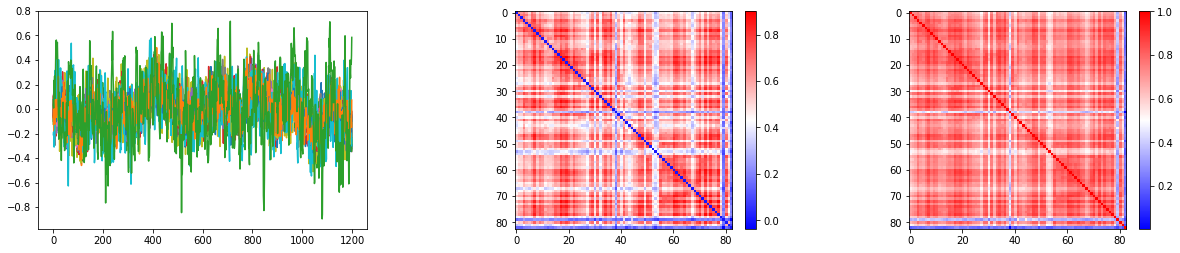

[0.408480002780141, 0.100001, 1.5664070019721983, 2.257461977005005, 17991.29460013847, 0.9576935649997489, 0.2294923961162567, 1.4454895982742308, 1.6713637948036195, 17991.552398608113]
7 196144


<Figure size 432x288 with 0 Axes>

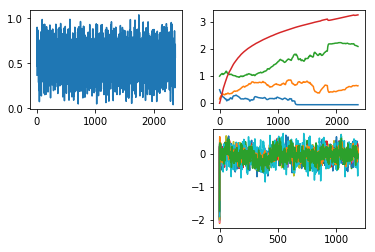

0.29163594648684343


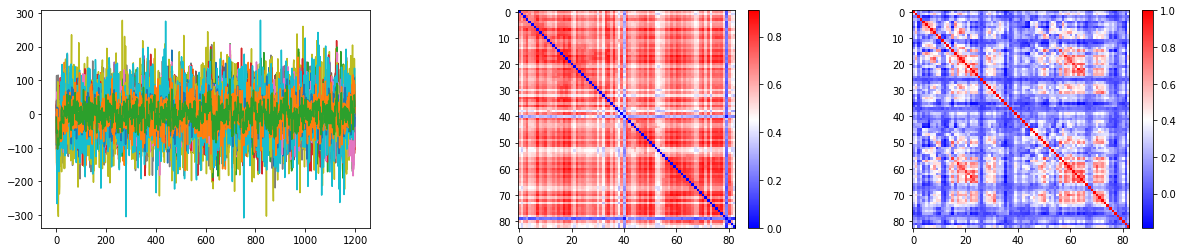

0.30129041454179406


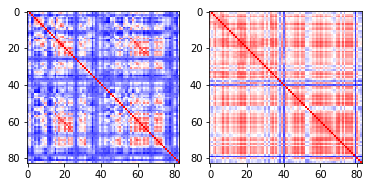

<Figure size 432x288 with 0 Axes>

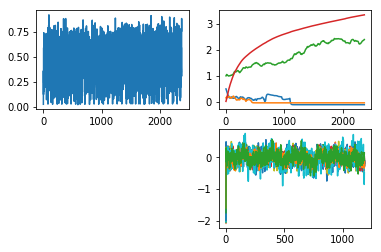

0.9715960433789457


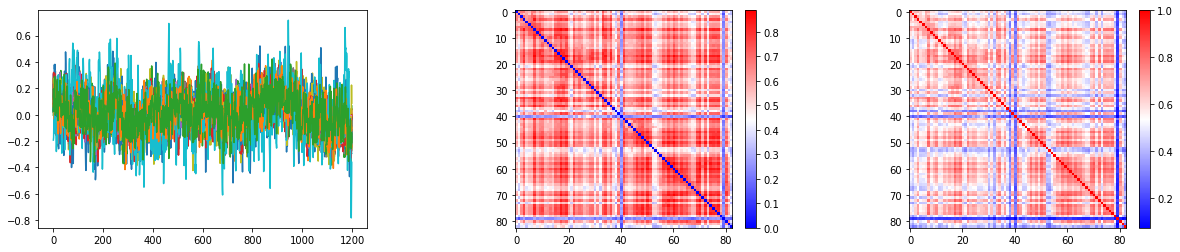

[0.29163594648684343, 0.100001, 0.6361741909980774, 2.2002605676651004, 17991.228673920174, 0.9715960433789457, 0.100001, 0.001001, 2.477910590171814, 17991.613919306557]
8 231928


<Figure size 432x288 with 0 Axes>

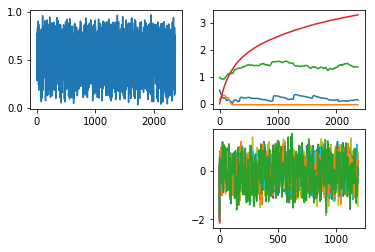

0.4515959031330092


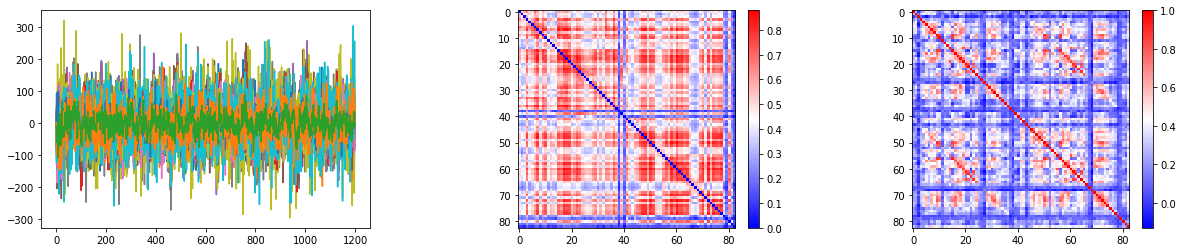

0.44565812240569314


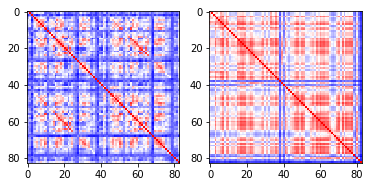

<Figure size 432x288 with 0 Axes>

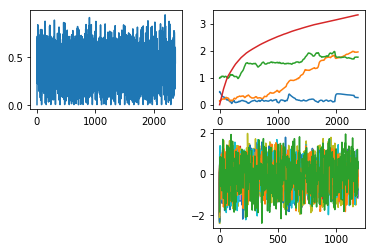

0.9724384733031418


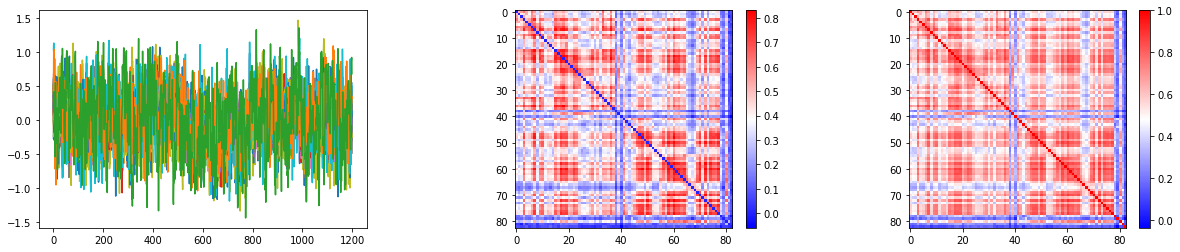

[0.4515959031330092, 0.25417531132698057, 0.001001, 1.4704033493995667, 17991.438729789425, 0.9724384733031418, 0.3737803786993027, 1.9566341409683226, 1.8652871966362001, 17991.570254919952]
9 579867


<Figure size 432x288 with 0 Axes>

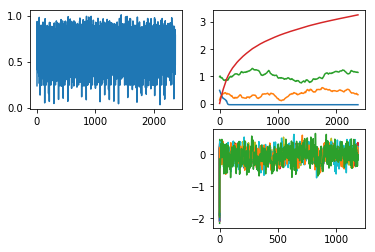

0.24769674796960256


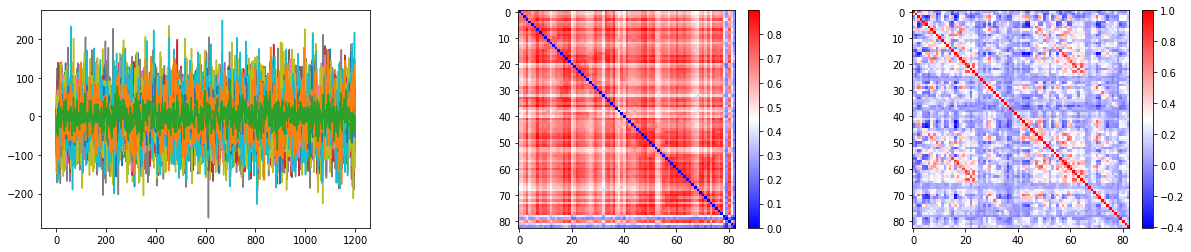

0.24685549274248708


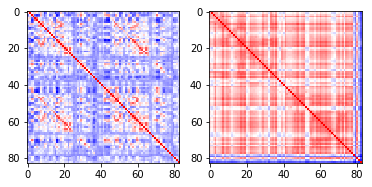

<Figure size 432x288 with 0 Axes>

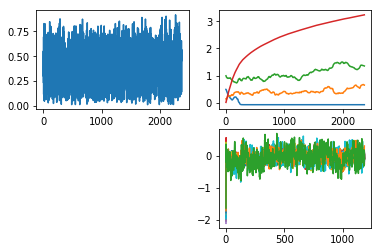

0.9814126547804343


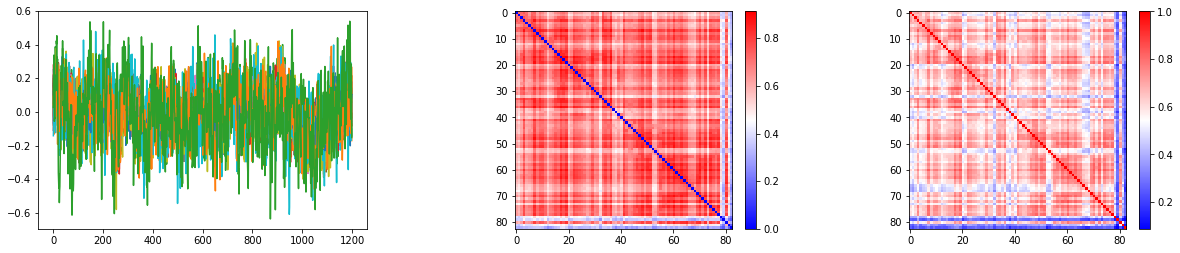

[0.24769674796960256, 0.100001, 0.33916364109516145, 1.2560915231704712, 17991.205174309078, 0.9814126547804343, 0.100001, 0.6507701585292817, 1.4548692226409914, 17991.05658443451]
10 146432
11 148941


<Figure size 432x288 with 0 Axes>

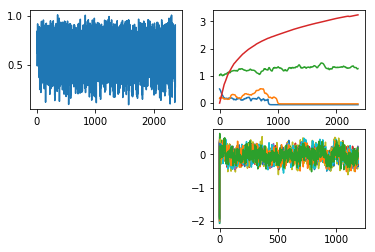

0.3201919596822677


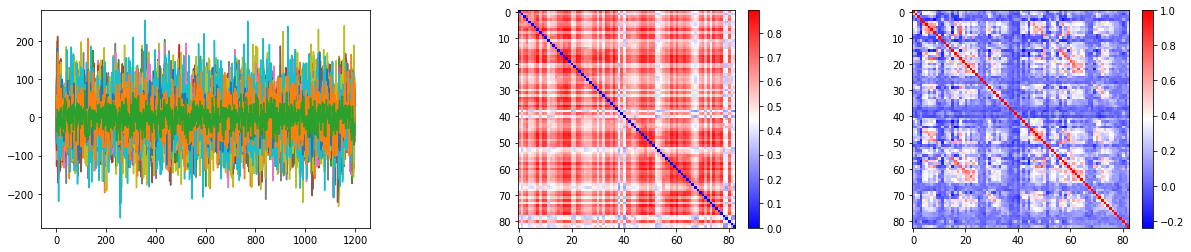

0.3239230950926595


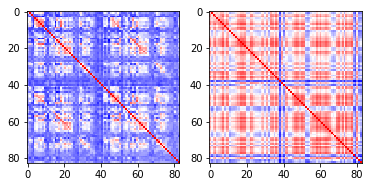

<Figure size 432x288 with 0 Axes>

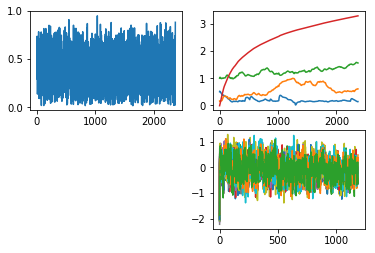

0.9566260260592209


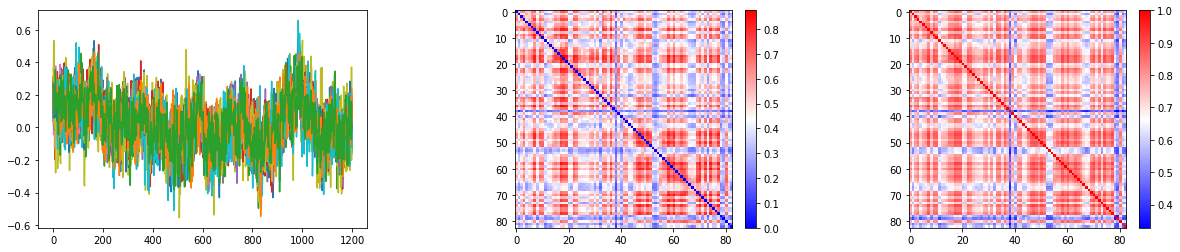

[0.3201919596822677, 0.100001, 0.001001, 1.3539236187934875, 17991.07974461615, 0.9566260260592209, 0.23872019499540328, 0.6127336511611938, 1.6704591512680054, 17991.472385369692]
12 100307


<Figure size 432x288 with 0 Axes>

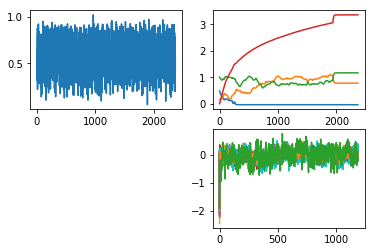

0.31877107875883276


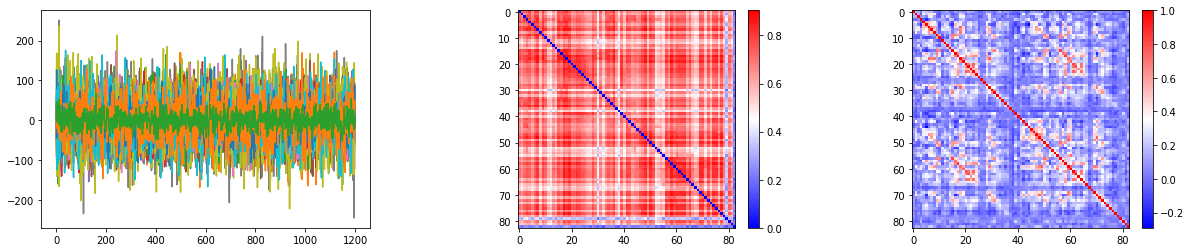

0.3264977512106292


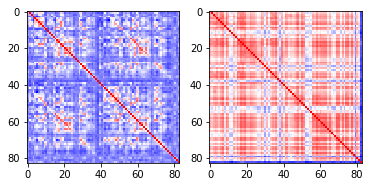

<Figure size 432x288 with 0 Axes>

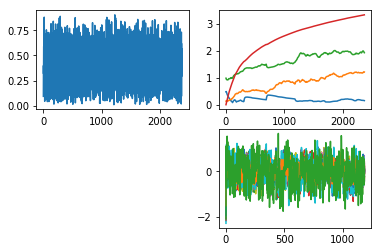

0.9657646564374459


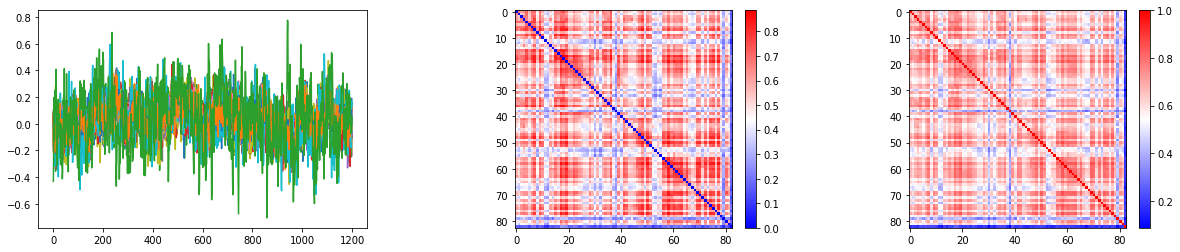

[0.31877107875883276, 0.100001, 0.7840093204975128, 1.271003019809723, 17991.69764209057, 0.9657646564374459, 0.2644939720630646, 1.2264368185997008, 2.048929989337921, 17991.588303573662]
13 709551
14 155938
15 198451


<Figure size 432x288 with 0 Axes>

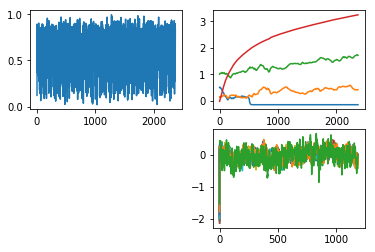

0.35396714724929784


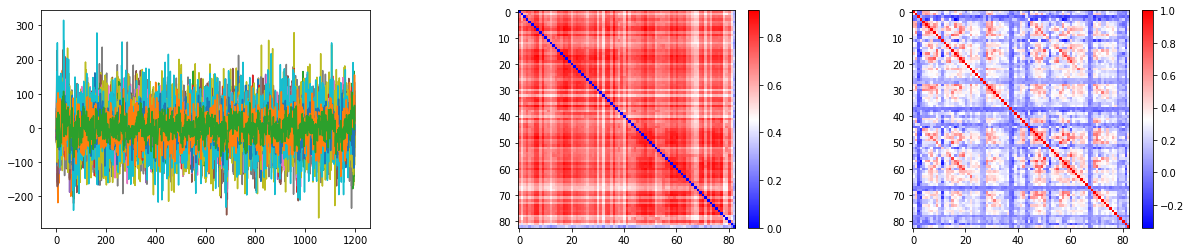

0.3833034716986299


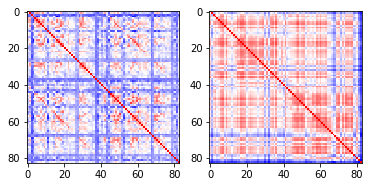

<Figure size 432x288 with 0 Axes>

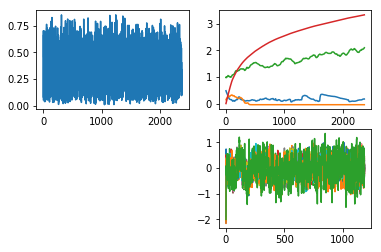

0.9726732511040243


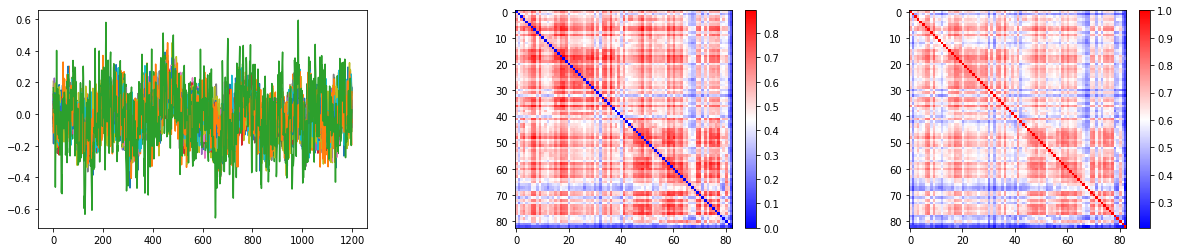

[0.35396714724929784, 0.100001, 0.4239084044694901, 1.8306053280830383, 17991.11003891036, 0.9726732511040243, 0.2799070253968239, 0.001001, 2.1833813428878783, 17991.602562920158]
16 311320


<Figure size 432x288 with 0 Axes>

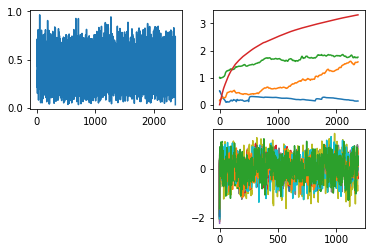

0.47700014353458625


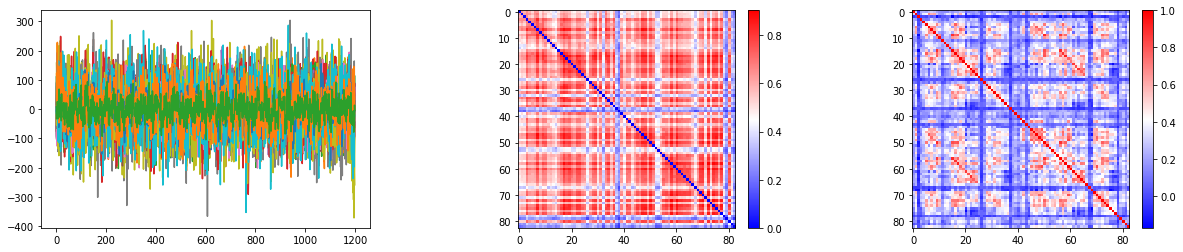

0.47141373024168304


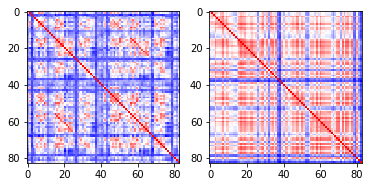

<Figure size 432x288 with 0 Axes>

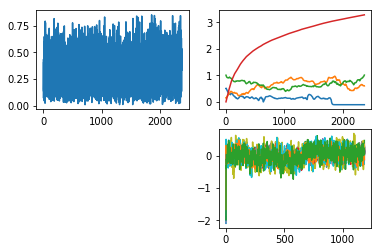

0.9698859714039757


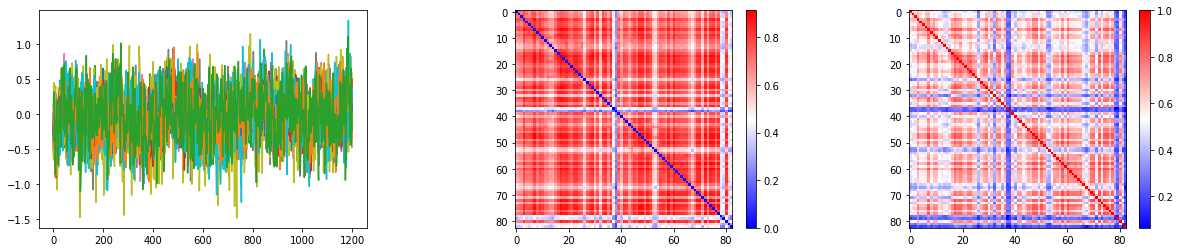

[0.47700014353458625, 0.24543254673480988, 1.5744800100326537, 1.849763810634613, 17991.476724667227, 0.9698859714039757, 0.100001, 0.6090450594425202, 1.0930808544158936, 17991.282480369617]
17 385450
18 173637


<Figure size 432x288 with 0 Axes>

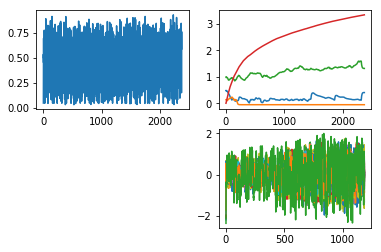

0.5248585364177671


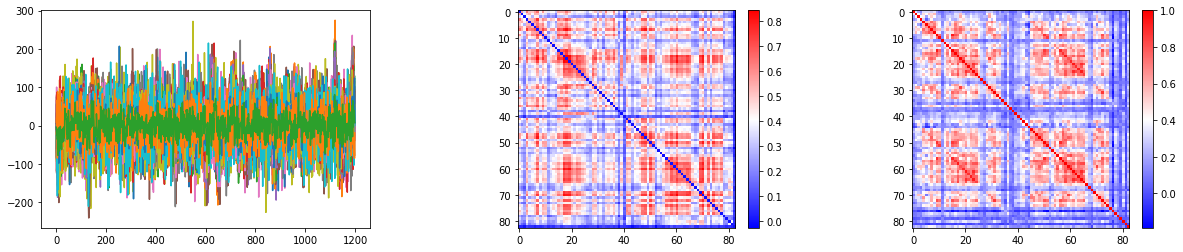

0.5405383983576969


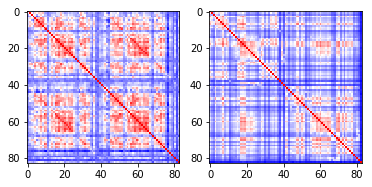

<Figure size 432x288 with 0 Axes>

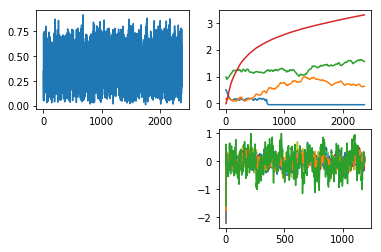

0.8997690772461739


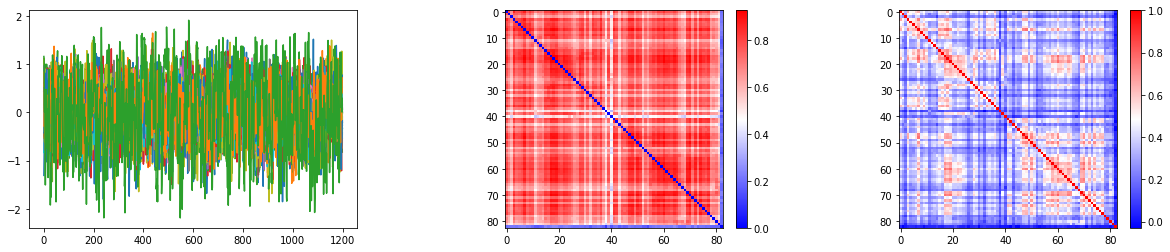

[0.5248585364177671, 0.5110487669706345, 0.001001, 1.4157585501670837, 17991.566084538117, 0.8997690772461739, 0.100001, 0.6397845396995544, 1.675455677509308, 17991.481730409116]
19 181636


<Figure size 432x288 with 0 Axes>

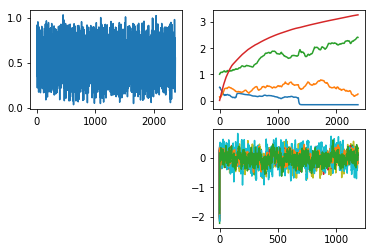

0.39222626514337505


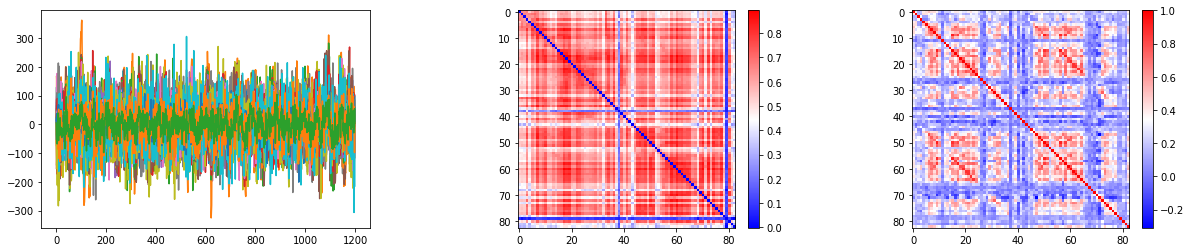

0.381943029537186


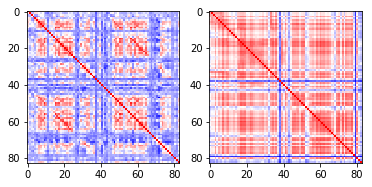

<Figure size 432x288 with 0 Axes>

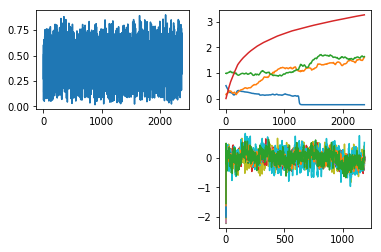

0.9590041388081231


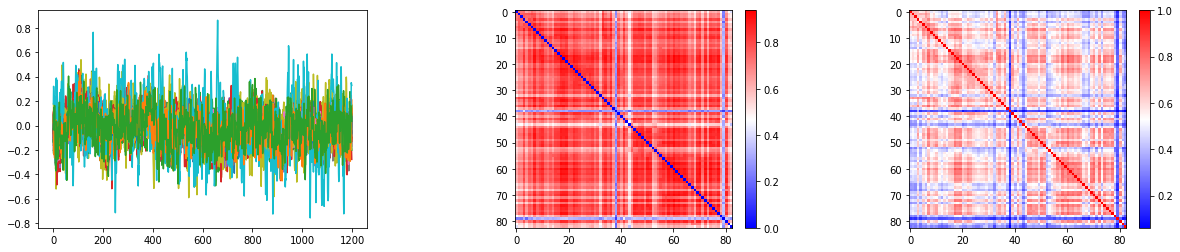

[0.39222626514337505, 0.100001, 0.23928572630882264, 2.522268772125244, 17991.284400221783, 0.9590041388081231, 0.100001, 1.596695400238037, 1.7328495979309082, 17991.206988086902]
20 290136


<Figure size 432x288 with 0 Axes>

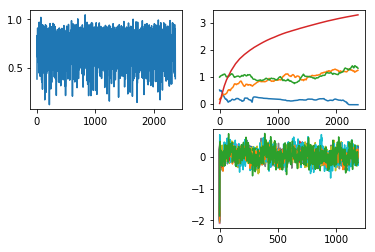

0.2737044893146899


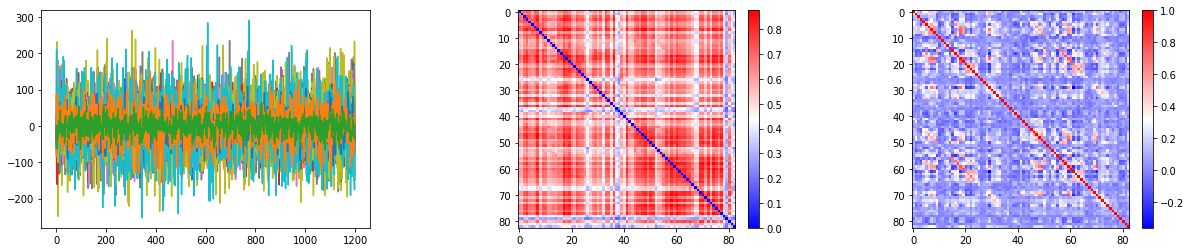

0.266434977231028


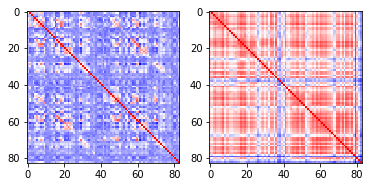

<Figure size 432x288 with 0 Axes>

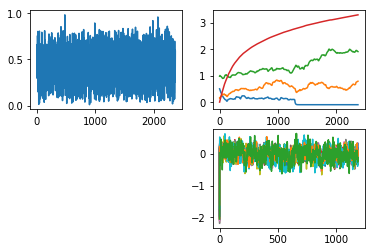

0.9818936873278197


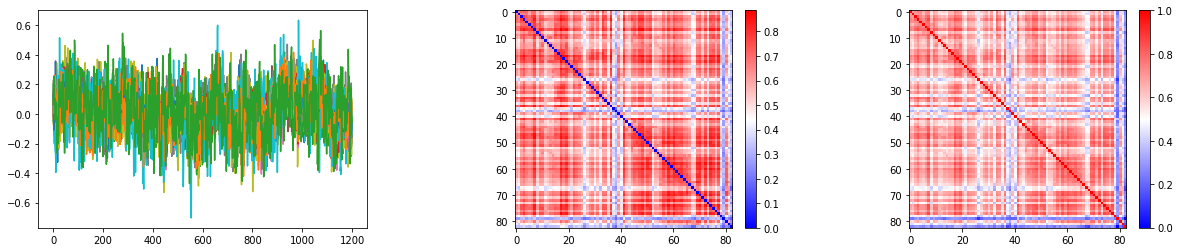

[0.2737044893146899, 0.100001, 1.2322497854232788, 1.4351018190383913, 17991.39084904855, 0.9818936873278197, 0.100001, 0.7946158180236816, 2.018844258785248, 17991.42502379361]
21 198653


<Figure size 432x288 with 0 Axes>

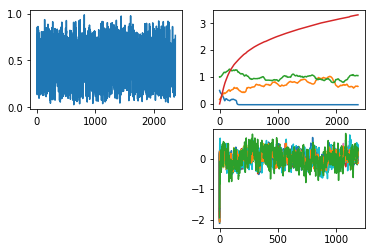

0.3225696197105716


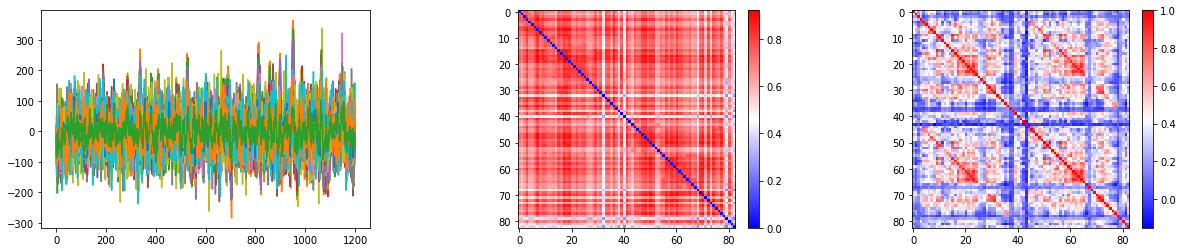

0.31444772335304605


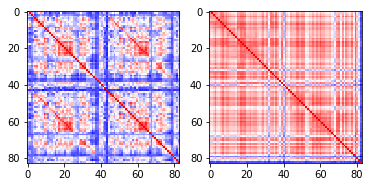

<Figure size 432x288 with 0 Axes>

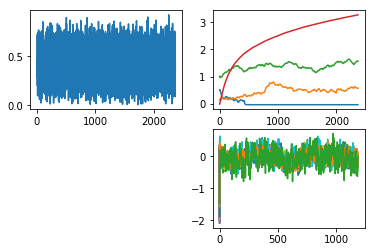

0.9815751557583885


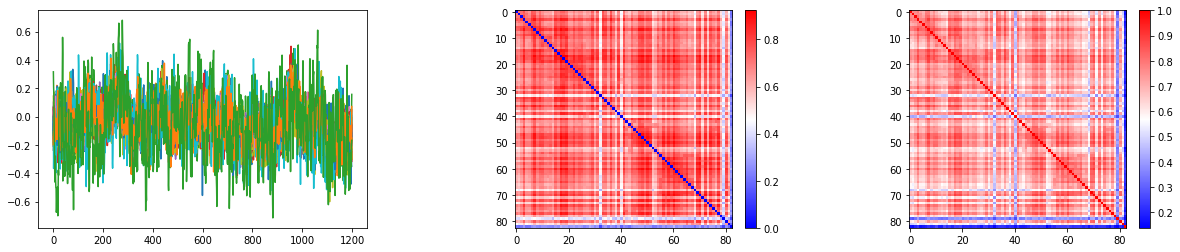

[0.3225696197105716, 0.100001, 0.6510642716884613, 1.1429588198661804, 17991.48272713626, 0.9815751557583885, 0.100001, 0.5722356865406036, 1.6730339407920838, 17991.270390802867]
22 157336


<Figure size 432x288 with 0 Axes>

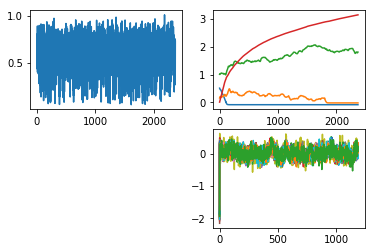

0.4028793385681272


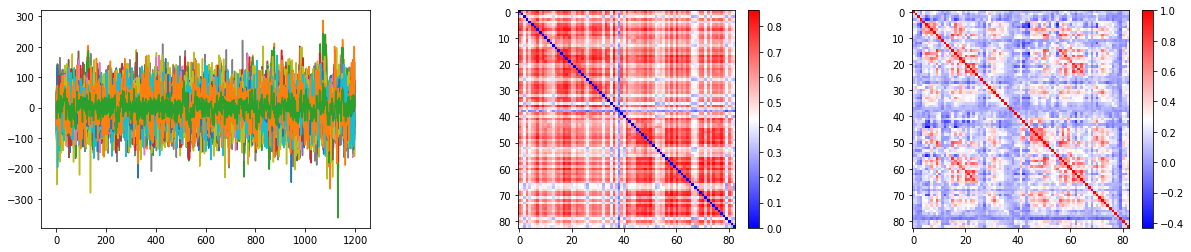

0.39305224304985814


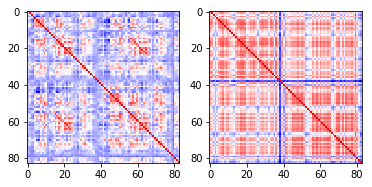

<Figure size 432x288 with 0 Axes>

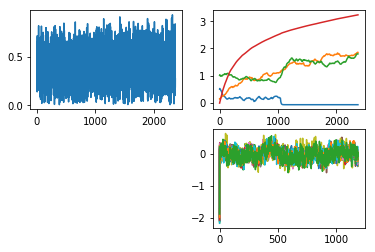

0.9754633171165891


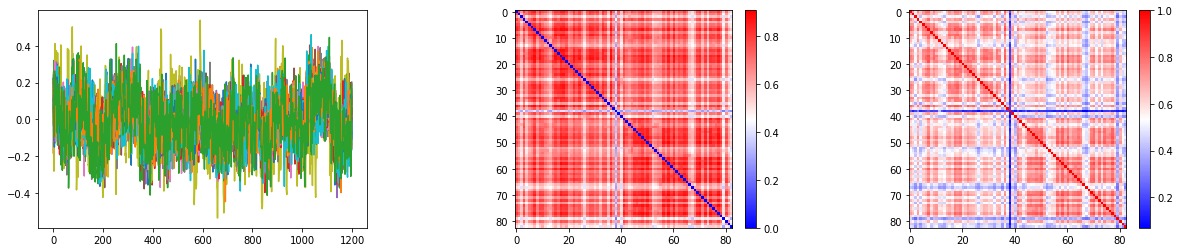

[0.4028793385681272, 0.100001, 0.001001, 1.8908351778984072, 17990.423897462882, 0.9754633171165891, 0.100001, 1.8548228154182433, 1.9016859769821168, 17991.05937365808]
23 121921
24 145127
25 567961


<Figure size 432x288 with 0 Axes>

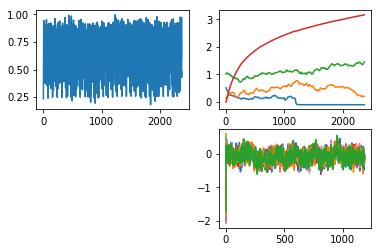

0.291670717666979


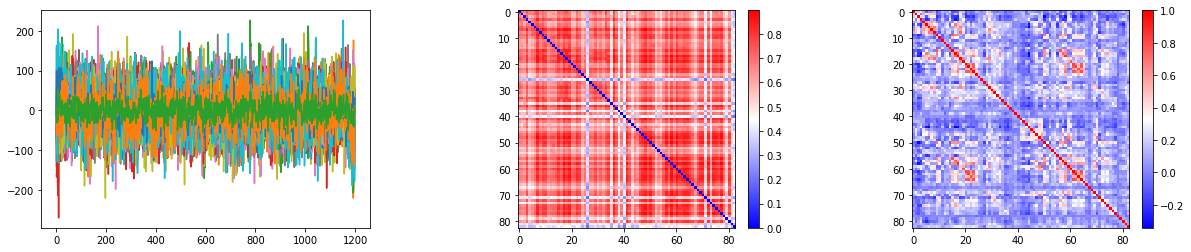

0.2888333157973489


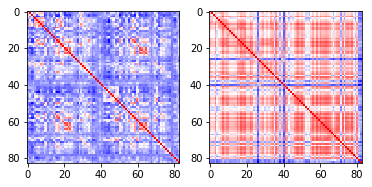

<Figure size 432x288 with 0 Axes>

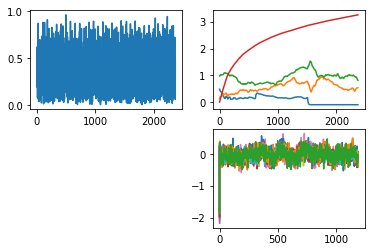

0.9796297897350514


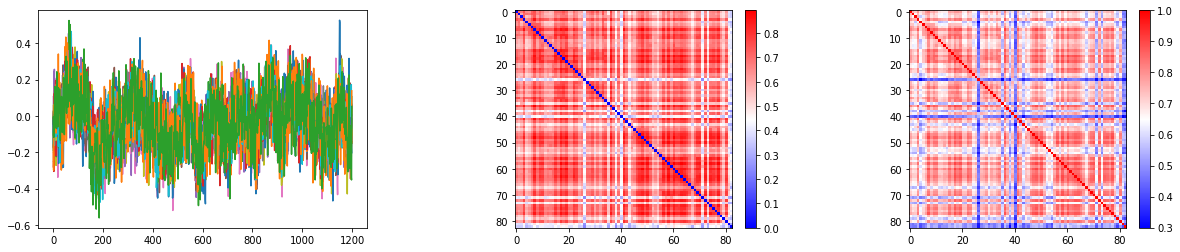

[0.291670717666979, 0.100001, 0.19910113608837127, 1.5366822361946106, 17990.570342961546, 0.9796297897350514, 0.100001, 0.5440240333080292, 0.9324415922164917, 17991.199667526238]
26 492754


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [30]:
batch_size = 83
HCP_par_corr= {}
ROI_size = 83
#groups= ['CON_MCI']

subs=[sub for sub in os.listdir(SC_base_dir) if os.path.isdir(SC_base_dir+sub)]
subs = subs[:30]
for i in range(len(subs)):
    sub =subs[i]
    print(i, sub)
    SC_file = SC_base_dir+ sub +'/dsi_sd4/sub-' +sub +'_roisc33dwispace/weights.txt'
    TS_file = TS_base_dir+sub+ '_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
#groups= ['CON_MCI']



    
    if os.path.isfile(SC_file) and os.path.isfile(TS_file):
        HCP_par_corr[sub] = []
        SC= np.loadtxt(SC_file)
        TS_df=pd.read_pickle(TS_file)
        TS=TS_df.values
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        SC = (SC+SC.T)*0.5
        """SC1=SC[:48,:48].copy()
        SC2=SC[48:96,48:96].copy()
        SC3=SC[:48,48:96].copy()
        mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
        SC1[mask1]=0
        SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
        SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
        SC[:48,:48] = SC1
        SC[48:96,48:96] = SC2
        SC[:48,48:96] = 1*SC3
        SC[48:96,:48] = 1*SC3.T"""
        Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
        #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
            
            
        num_data = TS.shape[0]

        total_series_length = num_data -echo_step #50000


        num_batches = total_series_length//truncated_backprop_length
            
        model_run(sub,Wo, TS)
    
        X0 = np.ones((6*batch_size,))/10.
        params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList_test1.txt')
        Theta = params[-10:,:].mean(axis = 0)

        tys=[]
        ROI_size= batch_size
        for j in range(4000):
            X = f_diffusion_tr_noise(X0,Wo, Theta)
        
            X0 = X
    
            tys.append(h_diffusion_noise(X0, Theta))
        
        tys=np.array(tys)
        #tys_dmean =(tys.T -tys.T.mean(axis= 0)).T
        FC_sim = np.corrcoef(tys[20:,:].T)
        FC=np.corrcoef(TS.T)
        np.savetxt(out_dir+'HCP_'+sub+'sim_bold_test1.txt', np.array(tys))
        print(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
        #HCP_par_corr[sub].append(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
            
    
        #HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[0:1])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[0:1])[0])
        HCP_par_corr[sub].append(.001+ smooth_normalize(Theta[1:2])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[2:3])[0])
        HCP_par_corr[sub].append(5000./0.459/0.641+1000.*np.tanh(Theta[3:4])[0])
        
        
            
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(FC, cmap='bwr')
        ax[1].imshow(FC_sim, cmap='bwr')
        plt.show()
        
        TS_file = out_dir+'HCP_'+sub+ 'sim_bold_test1.txt'
        TS=np.loadtxt(TS_file)
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        TS=TS[-1200:,:]
        
        model_run(sub,Wo, TS)
        params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList_test1.txt')
        Theta = params[-10:,:].mean(axis = 0)
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[0:1])[0])
        HCP_par_corr[sub].append(.001+ smooth_normalize(Theta[1:2])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[2:3])[0])
        HCP_par_corr[sub].append(5000./0.459/0.641+1000.*np.tanh(Theta[3:4])[0])
        print(HCP_par_corr[sub])
        

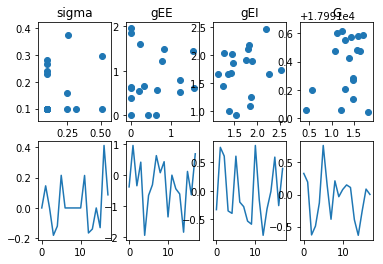

In [32]:
fig, ax=plt.subplots(2,4)
titles=['sigma', 'gEE', 'gEI','G']
for i in range(4):
    x_lis=[]
    y_lis=[]
    for sub in HCP_par_corr:
        if len(HCP_par_corr[sub])>0:
            x_lis.append(HCP_par_corr[sub][i+1])
            y_lis.append(HCP_par_corr[sub][i+1+5])
    ax[0,i].scatter(np.array(x_lis), np.array(y_lis))
    ax[0,i].set_title(titles[i])
    ax[1,i].plot(np.array(x_lis)- np.array(y_lis))
plt.show()
        

In [35]:
test=[[1,2],[3,4]]
test_a=np.array(test)
test_a

array([[1, 2],
       [3, 4]])

0 172332


<Figure size 432x288 with 0 Axes>

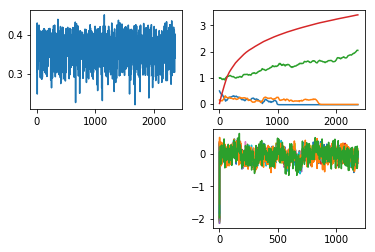

0.9826387576805508


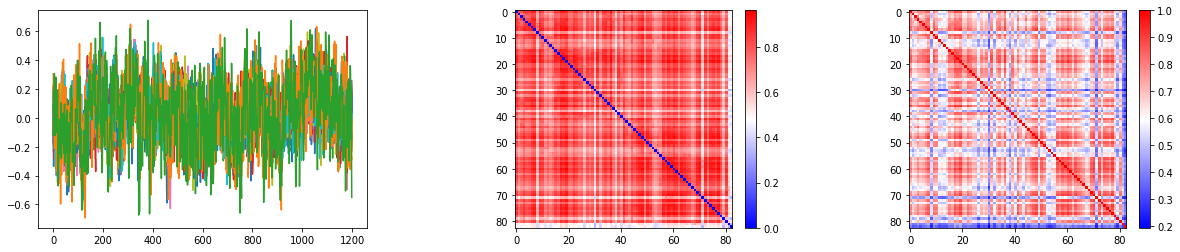

0.9858387824724298


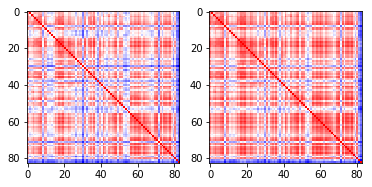

In [12]:
batch_size = 83
HCP_par_corr= {}
ROI_size = 83
#groups= ['CON_MCI']

subs=[sub for sub in os.listdir(SC_base_dir) if os.path.isdir(SC_base_dir+sub)]
subs = subs[3:4]
for i in range(len(subs)):
    sub =subs[i]
    print(i, sub)
    SC_file = SC_base_dir+ sub +'/dsi_sd4/sub-' +sub +'_roisc33dwispace/weights.txt'
    TS_file = out_dir+'HCP_'+sub+ 'sim_bold.txt'
#groups= ['CON_MCI']



    
    if os.path.isfile(SC_file) and os.path.isfile(TS_file):
        HCP_par_corr[sub] = []
        SC= np.loadtxt(SC_file)
        #TS_df=pd.read_pickle(TS_file)
        TS=np.loadtxt(TS_file)
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        SC = (SC+SC.T)*0.5
        """SC1=SC[:48,:48].copy()
        SC2=SC[48:96,48:96].copy()
        SC3=SC[:48,48:96].copy()
        mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
        SC1[mask1]=0
        SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
        SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
        SC[:48,:48] = SC1
        SC[48:96,48:96] = SC2
        SC[:48,48:96] = 1*SC3
        SC[48:96,:48] = 1*SC3.T"""
        Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
        #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
            
        TS=TS[-1200:,:]    
        num_data = TS.shape[0]

        total_series_length = num_data -echo_step #50000


        num_batches = total_series_length//truncated_backprop_length
            
        model_run(sub,Wo, TS)
    
        X0 = np.ones((6*batch_size,))/10.
        params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList_test.txt')
        Theta = params[-10:,:].mean(axis = 0)

        tys=[]
        ROI_size= batch_size
        for j in range(4000):
            X = f_diffusion_tr_noise(X0,Wo, Theta)
        
            X0 = X
    
            tys.append(h_diffusion_noise(X0, Theta))
        
        tys=np.array(tys)
        #tys_dmean =(tys.T -tys.T.mean(axis= 0)).T
        FC_sim = np.corrcoef(tys[20:,:].T)
        FC=np.corrcoef(TS[-1200:,:].T)
        np.savetxt(out_dir+'HCP_'+sub+'sim_bold_sim.txt', np.array(tys))
        print(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
        HCP_par_corr[sub].append(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
            
    
        #HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[0:1])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[0:1])[0])
        HCP_par_corr[sub].append(.001+ smooth_normalize(Theta[1:2])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[2:3])[0])
        HCP_par_corr[sub].append(5000./0.459/0.641+1000.*np.tanh(Theta[3:4])[0])
        """W_n_a = np.reshape(Theta[5:], [batch_size,batch_size])
        W_n_a = 1+ np.tanh((W_n_a+W_n_a.T)/2.0)
        W_n_a = W_n_a * Wo
    
        Ws_a = W_n_a/np.linalg.norm(W_n_a)
        HCP_par_corr[sub].extend(list(Ws_a.ravel()))"""
        
            
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(FC, cmap='bwr')
        ax[1].imshow(FC_sim, cmap='bwr')
        plt.show()


 

    


In [43]:
TS.shape

(4000, 83)

In [9]:
HCP_par_corr_new={}
for sub in HCP_par_corr:
    HCP_par_corr_new['sub'+sub] = HCP_par_corr[sub]

In [15]:
scipy.io.savemat(out_dir+'HCP_par_corr.mat', HCP_par_corr_new)
np.save(out_dir+'HCP_par_corr.npy', HCP_par_corr_new)

In [13]:
Theta

array([1.00000000e-06, 1.00000000e-06, 2.04831071e+00, 3.40517824e+00])

In [14]:
params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList.txt')
Theta_1 = params[-10:,:].mean(axis = 0)

In [15]:
Theta_1

array([ 0.04825384, -0.02333169,  2.31939886,  3.33760505])

In [16]:
sub

'172332'

In [17]:
#print(.1+ smooth_normalize(Theta[0:1])[0])
print(.1+ smooth_normalize(Theta[0:1])[0])
print(.001+ smooth_normalize(Theta[1:2])[0])
print(.1+ smooth_normalize(Theta[2:3])[0])
print(5000./0.459/0.641+1000.*np.tanh(Theta[3:4])[0])

0.100001
0.001001
2.148310708999634
17991.941645717114


In [18]:
#print(.1+ smooth_normalize(Theta_1[0:1])[0])
print(.1+ smooth_normalize(Theta_1[0:1])[0])
print(.001+ smooth_normalize(Theta_1[1:2])[0])
print(.1+ smooth_normalize(Theta_1[2:3])[0])
print(5000./0.459/0.641+1000.*np.tanh(Theta_1[3:4])[0])

0.1482538368552923
0.001001
2.419398856163025
17991.623383425005


In [47]:
params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList.txt')
Theta_1 = params[-10:,:].mean(axis = 0)

In [48]:
Theta_1

array([ 2.36034672, -0.09168791,  2.37867837,  2.89243062])

In [49]:
sub

'154532'

In [50]:
#print(.1+ smooth_normalize(Theta[0:1])[0])
print(.1+ smooth_normalize(Theta[0:1])[0])
print(.001+ smooth_normalize(Theta[1:2])[0])
print(.1+ smooth_normalize(Theta[2:3])[0])
print(5000./0.459/0.641+1000.*np.tanh(Theta[3:4])[0])

2.6454955101013184
0.001001
2.485164833068848
17987.14041777493


In [51]:
#print(.1+ smooth_normalize(Theta_1[0:1])[0])
print(.1+ smooth_normalize(Theta_1[0:1])[0])
print(.001+ smooth_normalize(Theta_1[1:2])[0])
print(.1+ smooth_normalize(Theta_1[2:3])[0])
print(5000./0.459/0.641+1000.*np.tanh(Theta_1[3:4])[0])

2.460346722602844
0.001001
2.4786783695220946
17988.015182082447
